<a href="https://colab.research.google.com/github/arielwendichansky/DI_Bootcamp/blob/master/Week9/Day4/Daily_challenge/A_B_testing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'ab-test-data:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F2479030%2F4213024%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240728%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240728T132307Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3Dbd823f8ff444eba75010e734d247290328f3a28907a0e30688ecbacaad5db78176cac2374416e13e4f81674dd78bae192ea3e77c15a08e5cb3906ef9809d3703df9d16f39fa9672c7205af47cb3af651d67facb0fa21dae9bbb7040a23de009e3a7cd8312b55058b65525aee6e22ba6d5f330e55973fc253eef6d980acd2433bd047416834f8834f300b2606d99c0c3244fa938c50ff78317024ceb5747f486f2c0605ac54e48388b501cfb9f4cf5692f7545f15913105daa1dd36c28319b4ddf83a99c480e147baf5285ddefd04092078a56f1268b2913e841fe4e03a4671572b25d20fb4faa07edc4f7e0772701943fd7ee6e98f010d76f9b35017a896db86'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 28963 bytes downloaded
Downloaded and uncompressed: ab-test-data
Data source import complete.


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
import statsmodels.stats.api as sms
import warnings
# Suppress specific warning
warnings.filterwarnings("ignore", message="scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate")

from scipy.stats import (ttest_1samp, shapiro, levene, ttest_ind, mannwhitneyu,
                         pearsonr, spearmanr, kendalltau, f_oneway, kruskal)
from statsmodels.stats.proportion import proportions_ztest
from statsmodels.stats.multicomp import MultiComparison
pd.set_option("display.width", 700)
pd.set_option("display.max_columns", None)
df = pd.read_csv("/kaggle/input/ab-test-data/AB_Test_Results.csv")
print(df.head())

   USER_ID VARIANT_NAME  REVENUE
0      737      variant      0.0
1     2423      control      0.0
2     9411      control      0.0
3     7311      control      0.0
4     6174      variant      0.0


# Data Understanding

In [3]:

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   USER_ID       10000 non-null  int64  
 1   VARIANT_NAME  10000 non-null  object 
 2   REVENUE       10000 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 234.5+ KB


In [4]:
df.columns

Index(['USER_ID', 'VARIANT_NAME', 'REVENUE'], dtype='object')

In [5]:
df.isnull().sum()

USER_ID         0
VARIANT_NAME    0
REVENUE         0
dtype: int64

In [6]:
df.describe()

,USER_ID,REVENUE
count,10000.000000,10000.000000
mean,4981.080200,0.099447
std,2890.590115,2.318529
min,2.000000,0.000000
25%,2468.750000,0.000000
50%,4962.000000,0.000000
75%,7511.500000,0.000000
max,10000.000000,196.010000


In [7]:
two_test_user = df[df['USER_ID'].duplicated() == True]
two_test_user.sort_values(by='USER_ID')

,USER_ID,VARIANT_NAME,REVENUE
7076,2,control,0.00
3479,2,control,0.00
7409,3,variant,0.00
5377,3,control,0.00
5545,10,control,0.00
...,...,...,...
6481,9986,variant,0.00
5673,9995,variant,0.00
5915,9996,variant,6.46
8921,10000,control,0.00


In [8]:
#counting unique users id
unique_user_ids = df['USER_ID'].unique()
num_unique_user_ids = len(unique_user_ids)
print(num_unique_user_ids)

6324


In [9]:
group_user = df.groupby(['USER_ID','VARIANT_NAME']).size().unstack(level='VARIANT_NAME',fill_value=0)
group_user

VARIANT_NAME,control,variant
USER_ID,,
2,3,0
3,1,2
4,0,1
5,0,1
6,0,1
...,...,...
9993,1,0
9995,0,2
9996,1,1


In [10]:
group_user['Total_test'] = group_user['control']+group_user['variant']
group_user = group_user.reset_index()
group_user

VARIANT_NAME,USER_ID,control,variant,Total_test
0,2,3,0,3
1,3,1,2,3
2,4,0,1,1
3,5,0,1,1
4,6,0,1,1
...,...,...,...,...
6319,9993,1,0,1
6320,9995,0,2,2
6321,9996,1,1,2
6322,9998,1,0,1


In [11]:
multiple_test = group_user[group_user['Total_test']>=2]
multiple_test

VARIANT_NAME,USER_ID,control,variant,Total_test
0,2,3,0,3
1,3,1,2,3
6,10,1,1,2
7,11,2,0,2
9,13,2,0,2
...,...,...,...,...
6313,9982,1,1,2
6315,9986,0,2,2
6320,9995,0,2,2
6321,9996,1,1,2


   control  duplicated control
0        1                1192
1        2                 775
2        3                 115
3        4                  13
4        5                   1
5        6                   1


Text(0.5, 1.0, 'Distribution Duplicated Control')

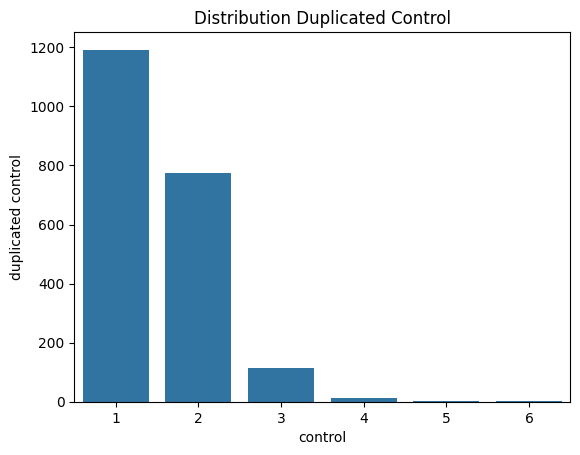

In [12]:
df_control = multiple_test[multiple_test['control']>0]
df_control = df_control.groupby('control')['control'].count().reset_index(name='duplicated control')
print(df_control)

sns.barplot(x= 'control', y= 'duplicated control', data = df_control)
plt.title('Distribution Duplicated Control')

   variant  duplicated variant
0        1                1180
1        2                 790
2        3                 111
3        4                  22
4        5                   1


Text(0.5, 1.0, 'Distribution Variant Control')

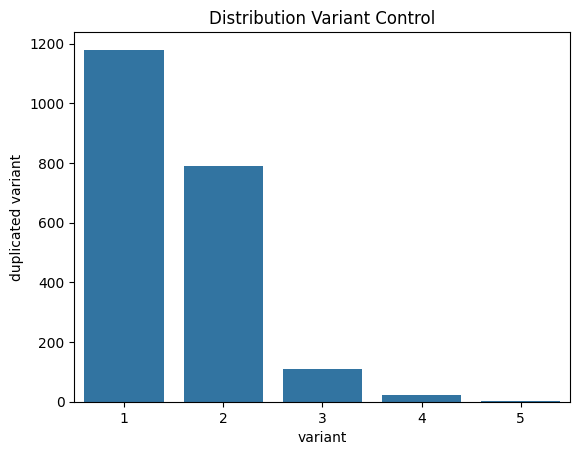

In [13]:
df_variant = multiple_test[multiple_test['variant']>0]
df_variant = df_variant.groupby('variant')['variant'].count().reset_index(name='duplicated variant')
print(df_variant)

sns.barplot(x='variant', y='duplicated variant', data= df_variant)
plt.title('Distribution Variant Control')


# Hypothesis assumption

* H0 : There is no significant difference in revenue brought by users between the control group (existing site version) and the variant group (modified site version) in the A/B test.

* Ha : There is a significant difference in revenue brought by users between the control group (existing site version) and the variant group (modified site version) in the A/B test, indicating that the modified version leads to either an increase or decrease in revenue compared to the existing version.



In [14]:
control = df.loc[df['VARIANT_NAME']=='control']
control_avg_rev = control['REVENUE'].mean()
print(f'The average control revenue is: {round(control_avg_rev,2)}')

The average control revenue is: 0.13


In [15]:
variant =  df[df['VARIANT_NAME']=='variant']
variant_avg_rev = variant['REVENUE'].mean()
print(f'The average variant revenue is: {round(variant_avg_rev,2)}')

The average variant revenue is: 0.07


# Assumptions Control:
*# 1- Normality Assumptions*
*# 2- Homogeneity of Variances Assumption*

# Shapiro-Wilk test

We use Shapiro-Wilk test to check the normality in the dataset, if there is a normal distribution.

* H0 : Assumes that the data follows a normal distribution.

* H1 : Assumes that the data does not follow a normal distribution.


In [16]:
control_rev = control['REVENUE']
variant_rev = variant['REVENUE']

In [17]:
shapiro_control = shapiro(control_rev)
shapiro_variant = shapiro(variant_rev)
print(f'Shapiro test for CONTROL:\n    {shapiro_control}')
print(f'\nShapiro test for VARIANT:\n    {shapiro_variant}')


Shapiro test for CONTROL:
    ShapiroResult(statistic=0.01833147442513483, pvalue=2.4983285100057203e-95)

Shapiro test for VARIANT:
    ShapiroResult(statistic=0.027033073451830147, pvalue=2.7310104028899288e-95)


Based on the p-values it can be concluded that

The p-value is extremely small (2.4983e-95) and (2.73e-95), which is far less than the significance level  0.05.
A small p-value indicates strong evidence against the null hypothesis.

Given the extremely small p-value, we reject the null hypothesis that the data is normally distributed. This means that the data provided does not follow a normal distribution.

Also, the p-value from the Shapiro-Wilk test may not be accurate when dealing with sample sizes larger than 5000

# Levene's test

Hypotheses for Levene's Test:

Null Hypothesis (H0): The variances are equal across the groups.

Alternative Hypothesis (H1): At least one group has a variance different from the others.

In [18]:
from scipy import stats

stat, p_value = stats.levene(control_rev,variant_rev)

print(f"Levene's test statistic: {stat}")
print(f"p-value: {p_value}")

Levene's test statistic: 1.6158565214488871
p-value: 0.2037000785338918


Test Statistic:

The test statistic value itself (1.6159) indicates how far the sample variances deviate from being equal, but it’s more meaningful in conjunction with the p-value.

Since the p-value is 0.2037, which is greater than 0.05, we do not reject the null hypothesis.

Conclusion: There is no significant evidence to suggest that the variances of the two models (or groups) are different.

# Non-Parametric Test (mannwhitneyu Test)

Based on the results of normality tests (Shapiro-Wilk, Anderson-Darling, and Kolmogorov-Smirnov) indicating non-normality in both groups, and considering that parametric assumptions are not met, the Mann-Whitney U test (a non-parametric test) would be a suitable choice for comparing the distributions of the Control and Variant groups in your A/B testing analysis.

In [23]:
# Perform Mann-Whitney U test
u_statistic, p_value = mannwhitneyu(control_rev, variant_rev)

print("Mann-Whitney U Test - U Statistic:", u_statistic)
print("Mann-Whitney U Test - p-value:", p_value)

Mann-Whitney U Test - U Statistic: 12521564.0
Mann-Whitney U Test - p-value: 0.47825247965294926


As the p value continues to be larger than 0.05 we do not have sufficient evidence to reject the null hypothesis. Therefore, accepting this means that there is not statistical difference between the median between control and variant.